# Lesson Introduction: Art Class
Build intuition through creativity

In [29]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax

plt.style.use('intuitivebayes.mplstyle')
figsize = (24,12)  

## Section 50: Seeing a full Gaussian process
* Taking a look at a good model of the Mauna Loa CO2 data

# Section 50: Gaussian Processes
The artist you've been waiting for

## The grand reveal

**Insert saved image of fully fit GP from below**

This is what you came here for. This plot is a gaussian rpocess, of course the main topic of this course. Just taking a look its evident this GP is able to do what a additive functions could not.

It also unlike the kernel density estimate conveys uncertainty.



## High level overview



**Insert picture of sky scrapers**

Now in this section while well be showing you a GP but we won't be explaining it all in detail. The goal of this section is to show you what a completed GP is, so in later lessons you'll have a frame of reference


In [30]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51) # the first 51 lines are metadata about the dataset

In [31]:
import pymc as pm
import aesara.tensor as at

## Prepare data
x = data["decimal date"].values - data["decimal date"].min()

y_mu = data["average"].mean()
y_sd = data["average"].std()
y = (data["average"].values - y_mu) / y_sd

y = data["average"].values

## Custom Kernel

In [32]:
## Make a new kernel!
class RandomWalk(pm.gp.cov.Covariance):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])

    def full(self, X, Xs=None):
        if Xs is None:
            Xs = X
        return at.minimum(X, at.transpose(Xs)) 

    def diag(self, X):
        return at.reshape(X, (-1, ))

We first start with a custom kernel. While might be new, the concept of a kernel you should be familiar with. Additionally you can see the term Covariance near the top. Covariance matrices, more precisely, will help us build custom kernels to fit all sorts of models which  you'll see later in the course. 

## The full Gaussian Process Model

Temporary Notes

Switch this to map estimates and explain whats going on


https://discord.com/channels/890472458585522187/942982611347845230/1003414261655158974

* Sure happy to tak about it, in short map estimates work alright, full posteriors are better obv, for gp.Marginal only, because you’ve already integrated out f (so the gp itself isn’t map estimated).  The reason is the crazy time savings, as you saw.  Map is a few seconds, MCMC is a few, months maybe? 
* if thats the case id say lets use map estimates and even call it and say, "usually using map estimates is not recommended but in this case its ok because of X,Y, and Z reason" 
* "it might not be "purist" math but thats not what this course is about. If you want that we recommend a phd" 

In [33]:
## PyMC model

coords = {'time': data['decimal date'].values}
with pm.Model(coords=coords) as model:
    
    # annual periodic component that decays over time
    eta_per = pm.HalfNormal("eta_per", sigma=10)
    ell_pdecay = pm.Gamma("ell_pdecay", alpha=10, beta=0.075)
    ell_psmooth = pm.Gamma("ell_psmooth", alpha=4, beta=3)
    period = 1.0 # annual cycles
    cov_seasonal = (
        eta_per**2 * pm.gp.cov.Periodic(1, period, ell_psmooth) * pm.gp.cov.ExpQuad(1, ell_pdecay)
    )
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # small/medium term irregularities
    eta_med = pm.HalfNormal("eta_med", sigma=10.0)
    ell_med = pm.Gamma("ell_med", alpha=2, beta=0.5)
    cov_medium = eta_med ** 2 * pm.gp.cov.Matern32(1, ell_med)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    eta_trend = pm.HalfNormal("eta_trend", sigma=50.0)
    ell_trend = pm.Gamma("ell_trend", alpha=12.0, beta=0.1)
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(1, ell_trend)
    c = pm.Gamma("c", mu=400, sigma=300.0)
    gp_trend = pm.gp.Marginal(mean_func=pm.gp.mean.Constant(c), cov_func=cov_trend)
    
    # short term random walk
    eta_rw = pm.HalfNormal("eta_rw", sigma=1.0)
    cov_rw = eta_rw**2 * RandomWalk()
    gp_rw = pm.gp.Marginal(cov_func=cov_rw)
    
    # The Gaussian process is a sum of these four components
    gp = gp_seasonal + gp_trend + gp_medium + gp_rw 

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    likelihood = gp.marginal_likelihood("likelihood", X=x[:, None], y=y, noise=sigma, dims="time")

Here's the whole thing all together. If you feel overwhelmed, good, it means you're awake! It might be apparent yet but a lot of this is already familiar to you.

In this model we have specified 
* Priors
* Two Kernels
* An additive form

and specified the type of GP we're using. There also is a couple things happening under the hood that PyMC takes care of us. But for now this specifies a fully model

## Estimating the parameters

In [34]:
## Inference using MCMC
## THis is incredibly slow
# with model:
#     inf_data_mcmc = pm.sample(draws=3000)

In [35]:
## Inference using ADVI

with model:
    mean_field = pm.fit(
        n=3000,
        method="advi", 
        callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")],
        obj_optimizer=pm.adamax(learning_rate=0.1),
    )

Finished [100%]: Average Loss = 221.41


In [36]:
idata = mean_field.sample(1000)

From we do what we do in all Bayesian models. Estimate our unknown parameter AND the uncertainty of each. 

## Plotting the posterior(s)

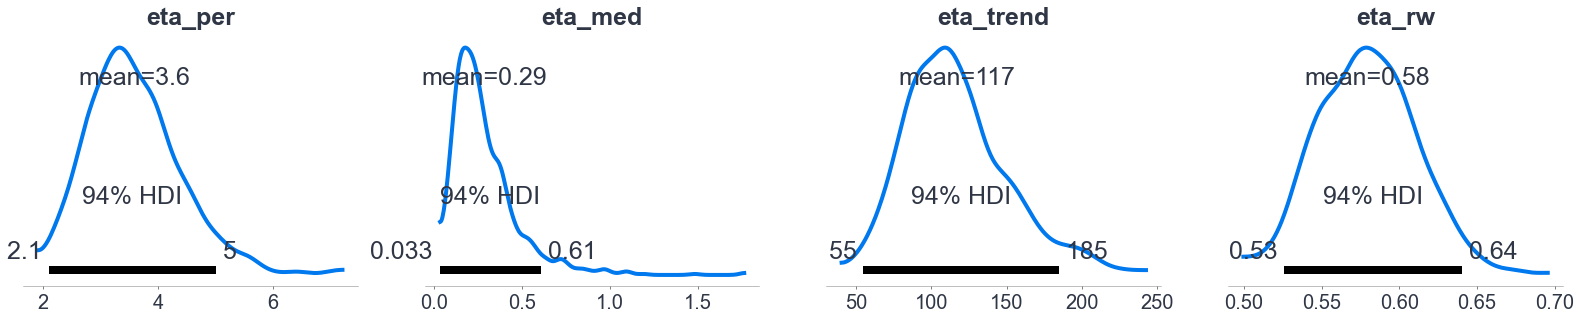

In [37]:
az.plot_posterior(idata, var_names=['eta_per', 'eta_med', 'eta_trend', 'eta_rw']);

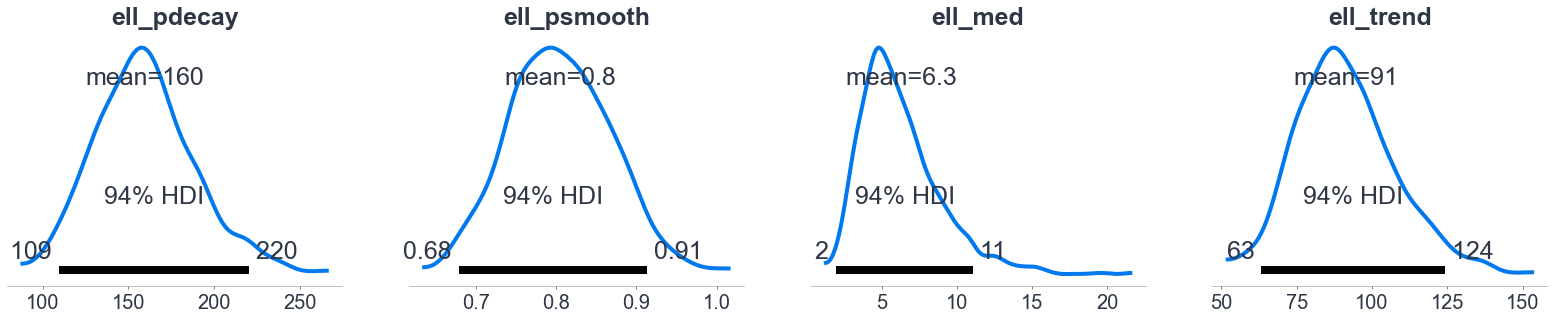

In [38]:
az.plot_posterior(idata, var_names=['ell_pdecay', 'ell_psmooth', 'ell_med', 'ell_trend']);

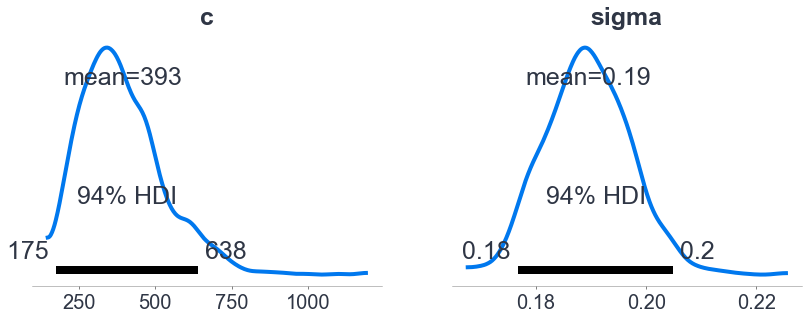

In [39]:
az.plot_posterior(idata, var_names=['c', 'sigma']);

The estimation parameters part you've seen in Section 10 and 20. Whats different here is these parameters are ones that you likely are unfamiliar with. One of these, ell, is the length scale. Sigma is another one you're familiar with, it captures the unmodeled noise. Eta and C we haven't covered yet however.

Unfortunately these don't have a tidy interpretation like a coefficient on a regression, where a change in X maps to a change in Y, but they provide their own flexibility and intuition thats quite valuable.

WIP Note:
It would be good to provide a little more explanation here. about eta C and sig

## Making Predictions

In [40]:
## Generate fit and forecast

xnew = np.linspace(2000, 2040, 700)
xnew = xnew - data["decimal date"].min()
with model:
    f = gp.conditional('f', Xnew=xnew[:, None])
    ppc = pm.sample_posterior_predictive(idata, samples=200, var_names=['f'], return_inferencedata=False)

/tmp/ipykernel_15053/1077669894.py:7: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  ppc = pm.sample_posterior_predictive(idata, samples=200, var_names=['f'], return_inferencedata=False)


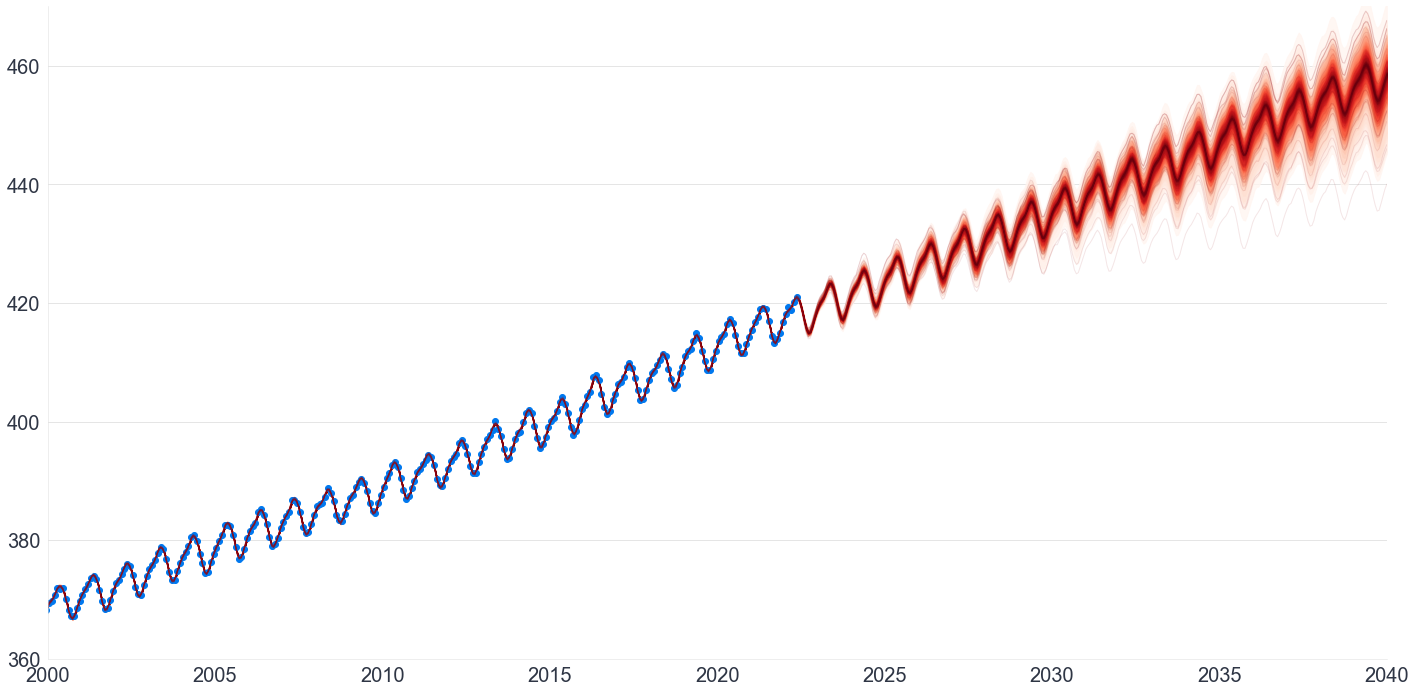

In [42]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
plt.plot(data['decimal date'], data['average'], 'o');

pm.gp.util.plot_gp_dist(ax, ppc['f'], xnew + data["decimal date"].min());

plt.xlim([2000, 2040]);
plt.ylim([360, 470]);

Like nay bayesian model GPs are also generate and can make predictions. Here's our mauna lao dataset but extended to 2040. We see everything we'd expect in this plot. The same trends continue out in the future, but also as we move farther and farther from the data our uncertainty increases. This type of uncertainty is called heteroskedastic uncertainty and is a step above where even many bayesian stop


After all of this just makes intuitive sense the farther we go into the future the less certain well be.

## Zoomed in

''

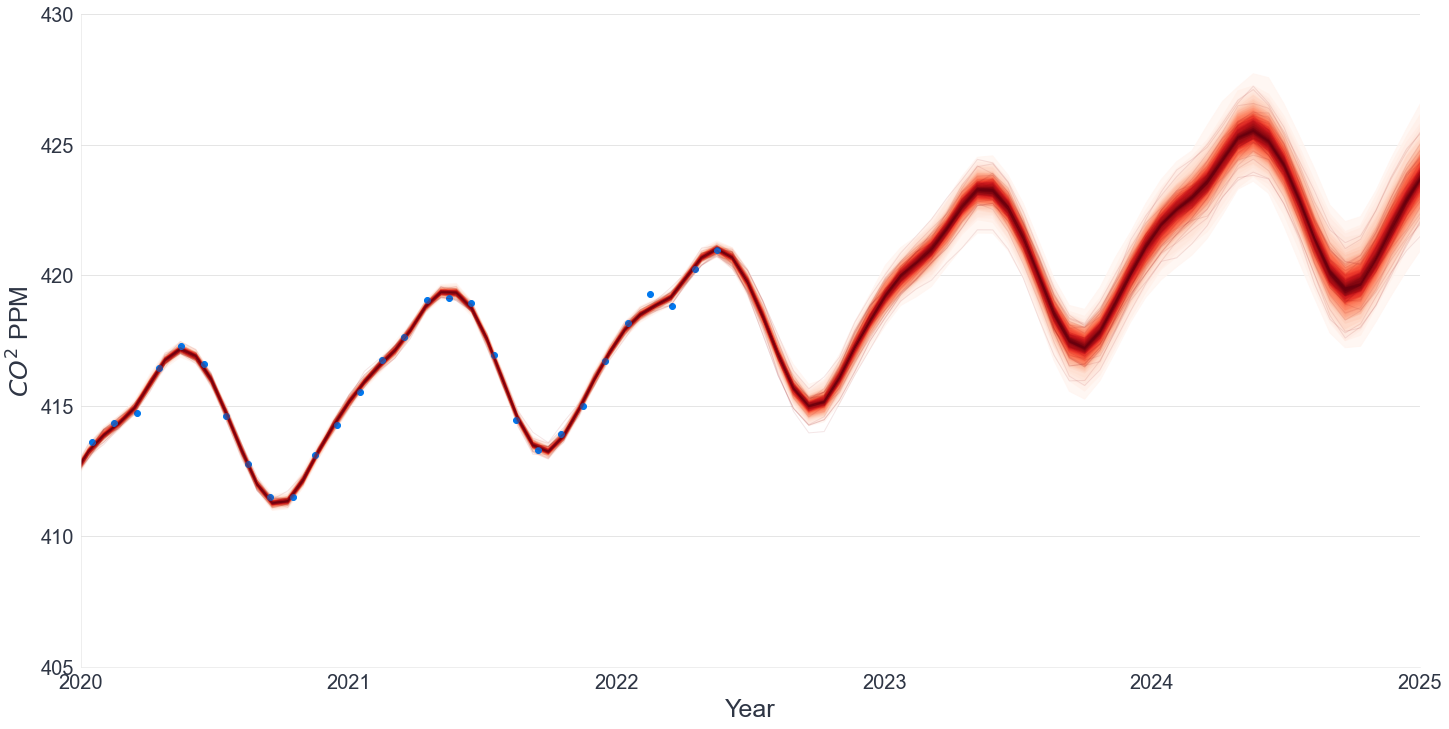

In [41]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
plt.plot(data['decimal date'], data['average'], 'o');

pm.gp.util.plot_gp_dist(ax, ppc['f'], xnew + data["decimal date"].min());

plt.xlim([2020, 2025])
plt.ylim([405, 430])

ax.set_xlabel("Year")
ax.set_ylabel("$CO^2$ PPM");

If we zoom into a smaller part of the series we can a better sense of the fit as well. The GP doesn't cross through every single point, that would be overfitting, but just like our KDE knowledge

# Each component of the GP

In [43]:
## Calculate the MAP (maximum a-posteriori) point from our ADVI fit 
mp = {name: float(val) for name, val in dict(idata.posterior.mean()).items()}

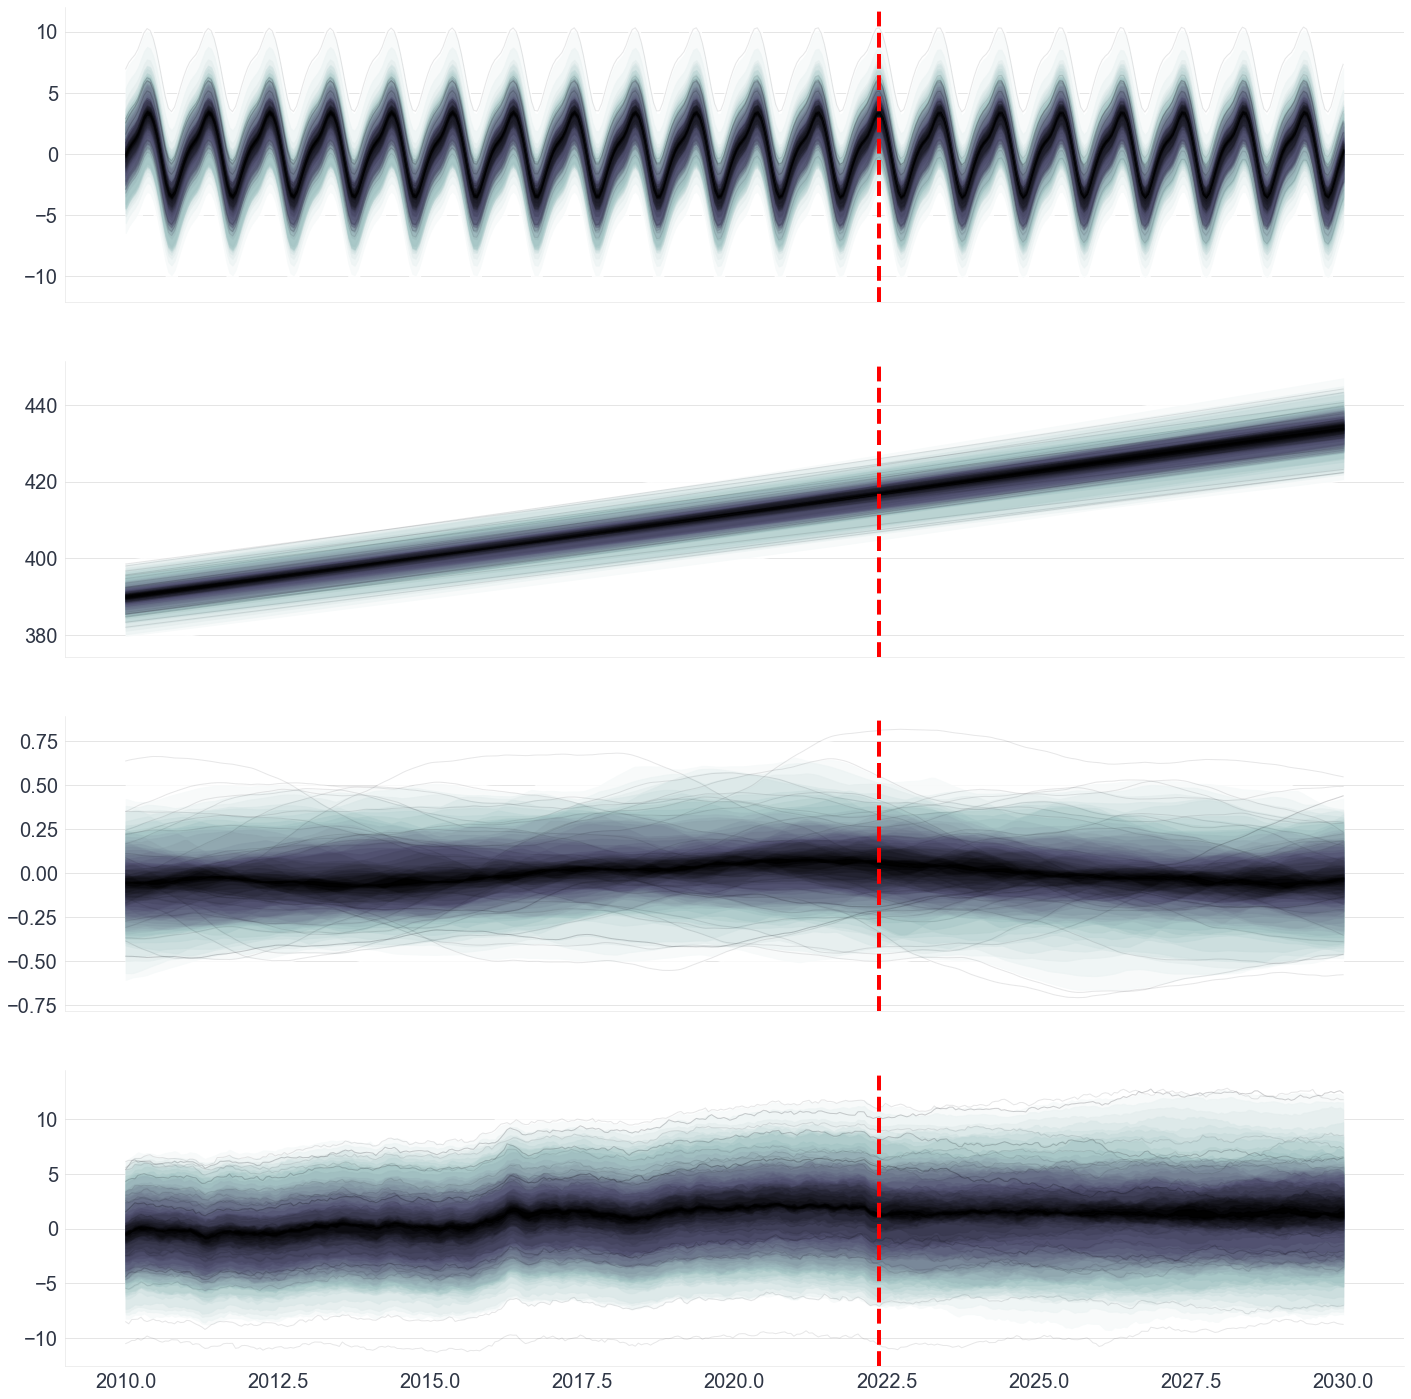

In [44]:
fig, axs = plt.subplots(4, 1, figsize=(24, 25), sharex=True)
axs = axs.flatten()

xnew = np.linspace(2010, 2030, 400)
xnew = xnew - data["decimal date"].min()
with model:
    ## plot seasonal
    mu, K = gp_seasonal.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": sigma}, diag=False
    )
    s = pm.draw(pm.MvNormal.dist(mu=mu, cov=K), 100)
    pm.gp.util.plot_gp_dist(axs[0], s, xnew + data["decimal date"].min(), palette="bone_r");
    axs[0].axvline(x=data["decimal date"].max(), color="r", linestyle="--");
    
    ## plot trend
    mu, K = gp_trend.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": sigma}, diag=False
    )
    s = pm.draw(pm.MvNormal.dist(mu=mu, cov=K), 100)
    pm.gp.util.plot_gp_dist(axs[1], s, xnew + data["decimal date"].min(), palette="bone_r");
    axs[1].axvline(x=data["decimal date"].max(), color="r", linestyle="--");
    
    ## plot medium/short term irregularity component
    mu, K = gp_medium.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": sigma}, diag=False
    )
    s = pm.draw(pm.MvNormal.dist(mu=mu, cov=K), 100)
    pm.gp.util.plot_gp_dist(axs[2], s, xnew + data["decimal date"].min(), palette="bone_r");
    axs[2].axvline(x=data["decimal date"].max(), color="r", linestyle="--");
    
    ## plot random walk component
    mu, K = gp_rw.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": sigma}, diag=False
    )
    s = pm.draw(pm.MvNormal.dist(mu=mu, cov=K), 100)
    pm.gp.util.plot_gp_dist(axs[3], s, xnew + data["decimal date"].min(), palette="bone_r");
    axs[3].axvline(x=data["decimal date"].max(), color="r", linestyle="--");

We can also plot each component separately, just like we did with our linear model that included a sine component. This ability of GPs to be composable of parts is another great piece of functionality. We can now get a sense of the trend independent of the seasonality. If you're coming from a stats background this might not be such a big deal, but if you're coming from a ML or AI background where models are more black box this should feel fantastic. Instead of just getting a bucket of weights you

## Take a breather

**insert some motivational picture of gif here**

This may seem like a lot of moving pieces, but taken together, the result is simple and I think, pretty elegant, and very useful.

In the next few lessons we're going to break down this GP into its individual pieces then bring it back up to the full model you see here.  This way you get a full in depth understanding which will enable you to to build your own GPs in any situation you encounter

## Section Recap
* GPs allowed us 
  * Make estimations without being locked into a functional model
  * Estimate each component separately
  * Make predictions for the future
  * Include heteroskedastic uncertainty in principled way
* Many pieces to a GP
  * Length Scale
  * Kernel
  * OTHER THING i MISSED
* Practical tips for fitting GPs
  * When facing real world problems theres tips to help move things along
  * Not something you'll find in a textbook but ones we'll cover here